In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torchvision import datasets,transforms
from PIL import Image
import json
import os
import scipy.misc
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
from shutil import copyfile, rmtree
import random
from tqdm import tqdm
%matplotlib inline
plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
#tools
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

def compute_iou(box1, box2):
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2

    ## 获取矩形框交集对应的左上角和右下角的坐标（intersection）
    xx1 = np.max([xmin1, xmin2])
    yy1 = np.max([ymin1, ymin2])
    xx2 = np.min([xmax1, xmax2])
    yy2 = np.min([ymax1, ymax2])
    
    ## 计算两个矩形框面积
    area1 = (xmax1-xmin1) * (ymax1-ymin1) 
    area2 = (xmax2-xmin2) * (ymax2-ymin2)
    
    inter_area = (np.max([0, xx2-xx1])) * (np.max([0, yy2-yy1]))
    iou = inter_area / (area1+area2-inter_area+1e-6)

    return iou

def showbbox(model, img):
    # 输入的img是0-1范围的tensor        
    model.eval()
    with torch.no_grad():
        '''
        prediction形如：
        [{'boxes': tensor([[1492.6672,  238.4670, 1765.5385,  315.0320],
        [ 887.1390,  256.8106, 1154.6687,  330.2953]], device='cuda:0'), 
        'labels': tensor([1, 1], device='cuda:0'), 
        'scores': tensor([1.0000, 1.0000], device='cuda:0')}]
        '''
        prediction = model([img.to(device)])
        
    # print(prediction[0]['scores'][0])
    
    # img=Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    img = img.detach()
    img=F.to_pil_image(img)
    # print(img)
    # show(img)
    # img = img.permute(1,2,0)  # C,H,W → H,W,C，用来画图
    # img = (img * 255).byte().data.cpu()  # * 255，float转0-255
    # img = np.array(img)  # tensor → ndarray
    

    # img = 255 * np.array(img).astype('uint8')
    # img=Image.fromarray(img)
    img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)  # PIL转cv2

    # print(img)

    for i in range(prediction[0]['boxes'].cpu().shape[0]):
        xmin = round(prediction[0]['boxes'][i][0].item())
        ymin = round(prediction[0]['boxes'][i][1].item())
        xmax = round(prediction[0]['boxes'][i][2].item())
        ymax = round(prediction[0]['boxes'][i][3].item())
        
        label = prediction[0]['labels'][i].item()
        
        if prediction[0]['scores'][i]>0.6:
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0),thickness=2)
            cv2.putText(img, str(label), (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0),thickness=2)
        
    
    # plt.figure(figsize=(20,15))
    # plt.imshow(img)
    return img
setup_seed(66)

In [3]:
#1 数据集处理
#1.1 plot box on all pic
# root="taobao/datasets/Live_demo_20200117/"
# pic_path=os.path.join(root,"image")
# pic_anno_path=os.path.join(root,"image_annotation")
# box_out_path=os.path.join(root,"image_box")

# pic_file_list=list(sorted(os.listdir(pic_path)))
# pic_anno_file_list=list(sorted(os.listdir(pic_anno_path)))
# cnts=[]

# for filedir in pic_file_list:

#     files=list(sorted(os.listdir(os.path.join(pic_path,filedir))))
#     pic_anno_files=list(sorted(os.listdir(os.path.join(pic_anno_path,filedir))))
#     cnt=0

#     for pic,pic_anno in zip(files,pic_anno_files):
#         with open(os.path.join(pic_anno_path,filedir,pic_anno),'r') as f:
#             dic=json.load(f)
#         torch_pic=torchvision.io.read_image(os.path.join(pic_path,filedir,pic))
#         boxes=[]

#         for ann in dic['annotations']:
#             if ann['instance_id']!=0:
#                 boxes.append(ann['box'])
        
#         boxes=torch.tensor(boxes,dtype=torch.float)
#         if boxes.nelement()==0:
#             continue
#         colors=["red","blue"]
#         result=draw_bounding_boxes(torch_pic,boxes,colors=colors,width=5)
#         if not(os.path.exists(os.path.join(box_out_path,filedir))):
#             os.mkdir(os.path.join(box_out_path,filedir))
#         torchvision.io.write_jpeg(result,os.path.join(box_out_path,filedir,pic))
#         cnt+=1
#         # show(result)
#     cnts.append(cnt)
#     # break
# print(cnts)
# print(sum(cnts))

In [4]:
# #1.2 modify datasets

# #1.2.1 for pic
# data_source_root_path="taobao/datasets/Live_demo_20200117/"
# data_target_root_path="taobao/datasets/NEW/"

# src_pic_path=os.path.join(data_source_root_path,"image")
# src_pic_anno_path=os.path.join(data_source_root_path,"image_annotation")
# tgt_pic_path=os.path.join(data_target_root_path,"image")
# tgt_pic_anno_path=os.path.join(data_target_root_path,"image_annotation")
# if not os.path.exists(tgt_pic_path):
#     os.mkdir(tgt_pic_path)
# if not os.path.exists(tgt_pic_anno_path):
#     os.mkdir(tgt_pic_anno_path)

# src_pic_filedirList=list(sorted(os.listdir(src_pic_path)))
# src_pic_anno_filedirList=list(sorted(os.listdir(src_pic_anno_path)))

# cnts=[]
# for filedir in src_pic_filedirList:
#     pic_files=list(sorted(os.listdir(os.path.join(src_pic_path,filedir))))
#     pic_anno_files=list(sorted(os.listdir(os.path.join(src_pic_anno_path,filedir))))
#     cnt=0
#     for pic,pic_anno in zip(pic_files,pic_anno_files):
#         with open(os.path.join(src_pic_anno_path,filedir,pic_anno),'r') as f:
#             dic=json.load(f)
#         pic_new_name = dic['item_id']+'_'+dic['img_name']
#         anno_new_name=dic['item_id']+'_'+dic['img_name'].split('.')[0]+".json"
        
#         dic['annotations']=list(filter(lambda x:x['instance_id']!=0,dic['annotations']))
#         if dic['annotations']==[]:
#             continue
#         #save pic and annotation
#         copyfile(os.path.join(src_pic_path, dic['item_id'], dic['img_name']), os.path.join(tgt_pic_path, pic_new_name))
#         with open(os.path.join(tgt_pic_anno_path,anno_new_name),'w') as anno_file:
#             json.dump(dic,anno_file)
#         cnt+=1
#     cnts.append(cnt)

# print(cnts)
# print(sum(cnts))

In [5]:
#1.2.2 for video
# data_source_root_path="taobao/datasets/Live_demo_20200117/"
# data_target_root_path="taobao/datasets/NEW/"

# src_video_path=os.path.join(data_source_root_path,"video")
# src_video_anno_path=os.path.join(data_source_root_path,"video_annotation")
# tgt_video_path=os.path.join(data_target_root_path,"video")
# tgt_video_frames_path=os.path.join(data_target_root_path,"video_frames")
# tgt_video_anno_path=os.path.join(data_target_root_path,"video_frames_annotation")
# tgt_video_anno_path1=os.path.join(data_target_root_path,"video_annotation")

# if not os.path.exists(tgt_video_path):
#     os.mkdir(tgt_video_path)
# if not os.path.exists(tgt_video_frames_path):
#     os.mkdir(tgt_video_frames_path)
# if not os.path.exists(tgt_video_anno_path):
#     os.mkdir(tgt_video_anno_path)
# if not os.path.exists(tgt_video_anno_path1):
#     os.mkdir(tgt_video_anno_path1)

# src_video_fileList=list(sorted(os.listdir(src_video_path)))
# src_video_anno_fileList=list(sorted(os.listdir(src_video_anno_path)))

# cnts=[]
# for video,video_anno in zip(src_video_fileList,src_video_anno_fileList):
#     copyfile(os.path.join(src_video_path,video),os.path.join(tgt_video_path,video))
#     copyfile(os.path.join(src_video_anno_path,video_anno),os.path.join(tgt_video_path1,video_anno))

#     with open(os.path.join(src_video_anno_path,video_anno),'r') as f:
#         dic=json.load(f)
#     if dic['video_id']=="000002":
#         continue
#     cap = cv2.VideoCapture(os.path.join(src_video_path, video))
#     frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

#     cnt=0
#     for frame in dic['frames']:
#         frame['annotations']=list(filter(lambda x:x['instance_id']!=0,frame['annotations']))
#         if frame['annotations']==[]:
#             continue
#         else:
#             frame_new_name=str(dic['video_id'])+"__"+str(frame['frame_index'])+".jpg"
#             frame_anno_new_name=str(dic['video_id'])+"__"+str(frame['frame_index'])+".json"

#             #save frame
#             cap.set(cv2.CAP_PROP_POS_FRAMES, frame['frame_index'])
#             ret,img=cap.read()
#             cv2.imwrite(os.path.join(tgt_video_frames_path,frame_new_name),img)
#             #save new json file
#             data={}
#             data['video_id']=dic['video_id']
#             data['annotations']=frame['annotations']
#             with open(os.path.join(tgt_video_anno_path,frame_anno_new_name),'w') as anno_file:
#                 json.dump(data,anno_file)
#         cnt+=1
#     cnts.append(cnt)

# print(cnts)
# print(sum(cnts))

In [6]:
# #1.3 #plot box on all video frame pic
# root="taobao/datasets/NEW/"
# pic_path=os.path.join(root,"video_frames")
# pic_anno_path=os.path.join(root,"video_frames_annotation")
# box_out_path=os.path.join(root,"boxed_video_frames")

# if not(os.path.exists(os.path.join(box_out_path))):
#     os.mkdir(os.path.join(box_out_path))

# pic_file_list=list(sorted(os.listdir(pic_path)))
# pic_anno_file_list=list(sorted(os.listdir(pic_anno_path)))

# pic_files=list(sorted(os.listdir(os.path.join(pic_path))))
# pic_anno_files=list(sorted(os.listdir(os.path.join(pic_anno_path))))
# cnt=0

# for pic,pic_anno in zip(pic_files,pic_anno_files):
#     with open(os.path.join(pic_anno_path,pic_anno),'r') as f:
#         dic=json.load(f)
    
#     if dic['video_id']=="000002":
#         continue
#     torch_pic=torchvision.io.read_image(os.path.join(pic_path,pic))
#     boxes=[]

#     for ann in dic['annotations']:
#         # if ann['instance_id']!=0:
#         boxes.append(ann['box'])
        
#     boxes=torch.tensor(boxes,dtype=torch.float)
#     if boxes.nelement()==0:
#         print(pic)
#         continue
#     colors=["red","blue","red","blue","red","blue"]
#     result=draw_bounding_boxes(torch_pic,boxes,colors=colors,width=5)

#     torchvision.io.write_jpeg(result,os.path.join(box_out_path,pic))
#     cnt+=1
#     # show(result)
# print(cnt)

In [7]:
# #1.4 random throw frames to image file
# setup_seed(66)

# image_path="taobao/datasets/NEW/imgPlusFrame"
# frame_path="taobao/datasets/NEW/video_frames"
# image_anno_path="taobao/datasets/NEW/imgPlusFrame_annotation"
# frame_anno_path="taobao/datasets/NEW/video_frames_annotation"
# img_test_path="taobao/datasets/NEW/img_test"
# img_test_anno_path="taobao/datasets/NEW/img_test_annotation"

# frames=list(sorted(os.listdir(frame_path)))
# frame_annos=list(sorted(os.listdir(frame_anno_path)))

# train_index=np.random.choice(np.arange(len(frames)),size=int(163),replace=False)
# print(sorted(train_index),len(train_index))
# train_index=sorted(train_index)
# # for idx in train_index:
# #     copyfile(os.path.join(frame_path,frames[idx]),os.path.join(image_path,frames[idx]))
# #     copyfile(os.path.join(frame_anno_path,frame_annos[idx]),os.path.join(image_anno_path,frame_annos[idx]))
# test_index=sorted(np.delete(np.arange(len(frames)),train_index))
# # for idx in test_index:
# #     copyfile(os.path.join(frame_path,frames[idx]),os.path.join(img_test_path,frames[idx]))
# #     copyfile(os.path.join(frame_anno_path,frame_annos[idx]),os.path.join(img_test_anno_path,frame_annos[idx]))
# print(test_index,len(test_index))

In [8]:
#1.5 count class num
pic_anno_path="taobao/datasets/NEW/image_annotation"
frame_anno_path="taobao/datasets/NEW/video_frames_annotation"

pic_annos=list(sorted(os.listdir(pic_anno_path)))
frame_annos=list(sorted(os.listdir(frame_anno_path)))

myset=set()

for pic_anno in pic_annos:
    with open(os.path.join(pic_anno_path,pic_anno),'r') as f1:
        dic1=json.load(f1)
    for ann in dic1['annotations']:
        myset.add(ann['instance_id'])

for frame_anno in frame_annos:
    with open(os.path.join(frame_anno_path,frame_anno),'r') as f2:
        dic2=json.load(f2)
    for ann in dic2['annotations']:
        myset.add(ann['instance_id'])
print(sorted(myset))
print(len(myset))

[20000101, 20000201, 20000301, 20000401, 20000501, 20000601, 20000701, 20000801, 20000901, 20001001, 20001101, 20001201, 20001301, 20001302, 20001401, 20001501, 20001601, 20001701, 20001801, 20001901, 20002001, 20002101, 20002201, 20002301, 20002401, 20002501]
26


In [9]:
#1.6 数据集定义
instance2label=[20000101, 20000201, 20000301, 20000401, 20000501, 20000601, 20000701, 20000801, 20000901, 20001001, 20001101, 20001201, 20001301, 20001302, 20001401, 20001501, 20001601, 20001701, 20001801, 20001901, 20002001, 20002101, 20002201, 20002301, 20002401, 20002501]
class TaobaoDataset(torch.utils.data.Dataset):
    def __init__(self,root,transforms=None):
        self.root=root
        self.transforms=transforms

        #load image
        self.imgs=list(sorted(os.listdir(os.path.join(root,"imgPlusFrame"))))
        self.img_anno=list(sorted(os.listdir(os.path.join(root,"imgPlusFrame_annotation"))))
        # self.videos=list(sorted(os.listdir(os.path.join(root,"video"))))
        # self.frames=list(sorted(os.listdir(os.path.join(root,"video_frames"))))
        # self.video_anno=list(sorted(os.listdir(os.path.join(root,"video_frames_annotation"))))

    def __getitem__(self,idx):
        #load images video box
        img_path=os.path.join(self.root,"imgPlusFrame",self.imgs[idx])
        img_anno_path=os.path.join(self.root,"imgPlusFrame_annotation",self.img_anno[idx])
        img=Image.open(img_path).convert("RGB")

        with open(img_anno_path,'r') as f:
            dic=json.load(f)
        boxes=[]
        labels=[]
        
        for ann in dic['annotations']:
            boxes.append(ann['box'])
            labels.append(ann['instance_id'])

        boxes=torch.as_tensor(boxes,dtype=torch.float32)
        labels=torch.as_tensor(labels,dtype=torch.int64)

        image_id=torch.tensor([idx])
        area=(boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        iscrowd=torch.zeros((len(dic['annotations']),),dtype=torch.int64)

        target={}
        target["boxes"]=boxes
        target["labels"]=torch.as_tensor([instance2label.index(label) for label in labels],dtype=torch.int64)
        target["image_id"]=image_id
        target["area"]=area
        target["iscrowd"]=iscrowd

        if self.transforms is not None:
            img,target=self.transforms(img,target)

        return img,target

    def __len__(self):
        return len(self.imgs)

In [10]:
#2 定义模型
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,progress=True,num_classes=26,pretrained_backbone=True)

In [17]:
model_choice=10

In [11]:
#3 数据增强
import utils
import transforms as T
from engine import train_one_epoch,evaluate

def get_transform(train):
    transforms=[]
    transforms.append(T.ToTensor()) 
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

In [12]:
#4 训练模型
root=r"taobao/datasets/NEW"

device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes=26

dataset=TaobaoDataset(root,get_transform(train=True))
dataset_val=TaobaoDataset(root,get_transform(train=False))

indices=torch.randperm(len(dataset)).tolist()
dataset=torch.utils.data.Subset(dataset,indices[:183])
dataset_val=torch.utils.data.Subset(dataset_val,indices[-60:])

data_loader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True,num_workers=0,collate_fn=utils.collate_fn)
data_loader_val=torch.utils.data.DataLoader(dataset_val,batch_size=1,shuffle=False,num_workers=0,collate_fn=utils.collate_fn)

model.to(device)

params=[p for p in model.parameters() if p.requires_grad]

#SGD
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

num_epochs=model_choice

for epoch in range(num_epochs):
    
    train_one_epoch(model,optimizer,data_loader,device,epoch,print_freq=50)
    
    lr_scheduler.step()

    evaluate(model,data_loader_val,device=device)

    print('')
    print('==================================================')
    print('')

print("finished!")

Epoch: [0]  [  0/183]  eta: 0:01:55  lr: 0.000032  loss: 3.9778 (3.9778)  loss_classifier: 3.2832 (3.2832)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.6917 (0.6917)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 0.6308  data: 0.0270  max mem: 1201
Epoch: [0]  [ 50/183]  eta: 0:01:12  lr: 0.001405  loss: 0.2680 (1.5465)  loss_classifier: 0.1411 (1.1500)  loss_box_reg: 0.0624 (0.0438)  loss_objectness: 0.0461 (0.3372)  loss_rpn_box_reg: 0.0158 (0.0156)  time: 0.5389  data: 0.0244  max mem: 1467
Epoch: [0]  [100/183]  eta: 0:00:46  lr: 0.002777  loss: 0.2529 (0.9300)  loss_classifier: 0.1499 (0.6656)  loss_box_reg: 0.0712 (0.0630)  loss_objectness: 0.0207 (0.1883)  loss_rpn_box_reg: 0.0064 (0.0131)  time: 0.5661  data: 0.0179  max mem: 1467
Epoch: [0]  [150/183]  eta: 0:00:18  lr: 0.004149  loss: 0.2345 (0.7321)  loss_classifier: 0.1301 (0.5141)  loss_box_reg: 0.0587 (0.0694)  loss_objectness: 0.0228 (0.1359)  loss_rpn_box_reg: 0.0063 (0.0127)  time: 0.5452  data: 0.0167  max mem: 1467


In [13]:
#5 保存模型
if num_epochs==10:
    torch.save(model,"1.pkl")
if num_epochs==20:
    torch.save(model,"2.pkl")
if num_epochs==30:
    torch.save(model,"3.pkl")

In [18]:
#6 测试效果
#6.1 load model

if num_epochs==10:
    model=torch.load("1.pkl")
if num_epochs==20:
    model=torch.load("2.pkl")
if num_epochs==30:
    model=torch.load("3.pkl")
model.to(device)





FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

tensor(0.0702, device='cuda:0')
tensor(0.0564, device='cuda:0')
tensor(0.0655, device='cuda:0')
tensor(0.0803, device='cuda:0')
tensor(0.0652, device='cuda:0')
tensor(0.0726, device='cuda:0')
tensor(0.0992, device='cuda:0')
tensor(0.1026, device='cuda:0')
tensor(0.1060, device='cuda:0')
tensor(0.0949, device='cuda:0')
tensor(0.0775, device='cuda:0')
[0, 0, 0, 11]


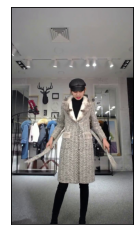

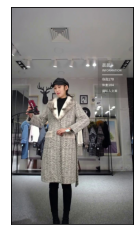

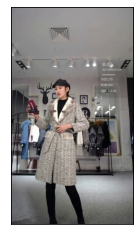

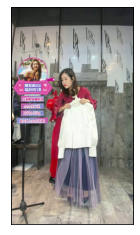

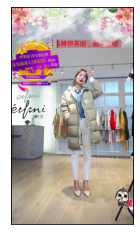

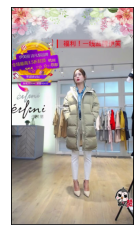

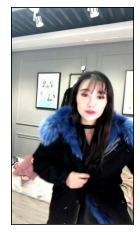

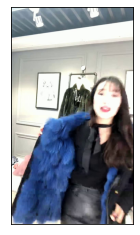

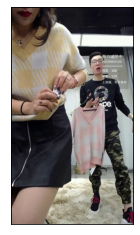

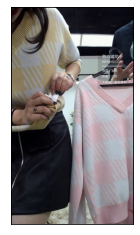

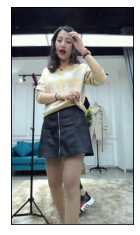

In [19]:
#6.2 对测试集内的图片进行预测
img_path="taobao/datasets/NEW/img_test/"

# img1=torchvision.io.read_image(img_path)

transform = transforms.ToTensor()

cnt=[0,0,0,0]
cnt1=0
test_files=list(sorted(os.listdir(img_path)))
for pic in test_files:
    img=Image.open(os.path.join(img_path,pic)).convert("RGB")
    img = transform(img)
    with torch.no_grad():
        prediction=model([img.to(device)])

    print(prediction[0]['scores'][0])
    score_threshold=0.6
    boxes=[]
    for prediction_ in prediction:
        b=prediction_['boxes'][prediction_['scores']>score_threshold].cpu().numpy()
        for item in b:
            boxes.append(item)
    boxes=torch.tensor(boxes,dtype=torch.float)
    p=torchvision.io.read_image(os.path.join(img_path,pic))
    result=draw_bounding_boxes(p,boxes,width=5)
    show(result)

    if prediction[0]['scores'][0]>0.9:
        cnt[0]+=1
    elif prediction[0]['scores'][0]>0.8:
        cnt[1]+=1
    elif prediction[0]['scores'][0]>0.7:
        cnt[2]+=1
    else:
        cnt[3]+=1
    cnt1+=1
    if cnt1>10:
        break
print(cnt)

# print(boxes)


In [28]:
#6.3 截取视频中一张图预测
video_path="taobao/datasets/NEW/video"
src_video_fileList=list(sorted(os.listdir(video_path)))
transform = transforms.ToTensor()

cnt=[0,0,0,0]
for video in src_video_fileList:
    if video.split('.')[0]=="000002":
        print("002!")
        continue
    cap = cv2.VideoCapture(os.path.join(video_path, video))
    frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    cap.set(cv2.CAP_PROP_POS_FRAMES, 20)
    ret,img=cap.read()
    # print(type(img))
    img=transform(img)
    # show(img)
    # print(type(img))
    
    with torch.no_grad():
        prediction=model([img.to(device)])

    if prediction[0]['scores'].cpu().numpy().size>0:
        print(prediction[0]['scores'][0],prediction[0]['labels'][0])
        showbbox(model,img)

    # cv2.imwrite(os.path.join(tgt_video_frames_path,frame_new_name),img)

tensor(0.0640, device='cuda:0') tensor(4, device='cuda:0')
002!
tensor(0.0740, device='cuda:0') tensor(4, device='cuda:0')
tensor(0.0691, device='cuda:0') tensor(11, device='cuda:0')
tensor(0.0883, device='cuda:0') tensor(4, device='cuda:0')
tensor(0.0789, device='cuda:0') tensor(11, device='cuda:0')
tensor(0.1359, device='cuda:0') tensor(11, device='cuda:0')
tensor(0.1251, device='cuda:0') tensor(11, device='cuda:0')
tensor(0.0988, device='cuda:0') tensor(4, device='cuda:0')
tensor(0.0644, device='cuda:0') tensor(11, device='cuda:0')
tensor(0.0915, device='cuda:0') tensor(10, device='cuda:0')
tensor(0.2033, device='cuda:0') tensor(11, device='cuda:0')
tensor(0.1255, device='cuda:0') tensor(11, device='cuda:0')
tensor(0.1270, device='cuda:0') tensor(11, device='cuda:0')
tensor(0.0964, device='cuda:0') tensor(4, device='cuda:0')
tensor(0.1640, device='cuda:0') tensor(11, device='cuda:0')
tensor(0.1253, device='cuda:0') tensor(11, device='cuda:0')
tensor(0.0512, device='cuda:0') tensor(4

In [29]:
#6.4 对整个视频预测 输出视频 投票机制 S1得分
from tqdm import tqdm
path="taobao/datasets/NEW/video/"
anno_path="taobao/datasets/NEW/video_annotation"
video_list=list(sorted(os.listdir(path)))
video_anno_list=list(sorted(os.listdir(anno_path)))

transform = transforms.ToTensor()
model=torch.load("1.pkl")
model.to(device)

N_tp=0  #true positive
N_p=0   #positive
N_gt=0  #ground turth

result=[]
for video,anno in zip(video_list,video_anno_list):
    cap = cv2.VideoCapture(os.path.join(path,video))
    fps=cap.get(cv2.CAP_PROP_FPS)
    size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
            int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # print(fps,size,frames)
    # videoWriter = cv2.VideoWriter(
    #         # "save.avi", cv2.VideoWriter_fourcc(*'XVID'), 25.0, (640, 480))
    #         # "save.mp4", cv2.VideoWriter_fourcc(*'MJPG'), 20.0, (720, 1280))
    #         path.split('/')[-1].split('.')[0]+".avi", cv2.VideoWriter_fourcc(*'MJPG'), 20.0, (720,1280))

    with open(os.path.join(anno_path,anno),'r') as f:
        dic=json.load(f)
    count_num=set({})
    for frame in dic['frames']:
        for ann in frame['annotations']:
            if ann['instance_id']!=0:
                count_num.add(ann['instance_id'])
    N_gt+=len(count_num)

    sample_num=10
    scores=np.zeros(26,int)
    prob=np.ones(26,float)
    fake_scores=np.zeros(26,int)
    fake_prob=np.ones(26,float)
    for i in range(int(frames/sample_num)):
    # for i in tqdm(range(int(frames/sample_num))):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i*sample_num)
        ret,img=cap.read()
        img=transform(img)

        #img=showbbox(model,img)
        # #videoWriter.write(img)

        with torch.no_grad():
            prediction=model([img.to(device)])

        score_threshold=0.8
        fake_scores[prediction[0]['labels'][0]]+=1
        fake_prob[prediction[0]['labels'][0]]*=(1.0-prediction[0]['scores'][0])
        for score,label in zip(prediction[0]['scores'],prediction[0]['labels']):
            if score>=score_threshold:
                scores[label]+=1
                prob[label]*=(1-score)
                # print(f"{label}:{score}")

    # print(scores)

    # pred_num=len(np.where(prob<=1.0e-12)[0])
    fake_prob_threshold=1e-12
    ans=np.where(scores==np.max(scores))[0]
    result.append(ans)
    is_sucess=False
    if np.max(scores)!=0:
        for a in ans:
            N_p+=1
            if instance2label[a] in count_num:
                is_sucess=True
                N_tp+=1
        print(f"{video}:{ans} get_score:{[scores[a] for a in ans]} and false positive prob:{[prob[a] for a in ans]} {is_sucess}")
    else:
        most_vote=np.where(fake_scores==np.max(fake_scores))[0]
        max_fake_prob=fake_prob[np.where(fake_scores==np.max(fake_scores))[0]]
        if max_fake_prob<fake_prob_threshold:
            N_p+=1
            for m in most_vote:
                if instance2label[m] in count_num:
                    is_sucess=True
                    N_tp+=1
            print(f"{video}:maybe{most_vote} and false positive prob:{max_fake_prob} {is_sucess}")

P=N_tp/N_p
R=N_tp/N_gt
S1_Score=2*P*R/(P+R)
print("====================================================================")
print(f"model:{model_choice} epoch trained")
print(f"N_tp={N_tp} N_p={N_p} N_gt={N_gt}")
print(f"S1: P={P} R={R} Score={S1_Score}")
# print(result)

000004.mp4:[3] get_score:[41] and false positive prob:[0.0] True
000005.mp4:[4] get_score:[21] and false positive prob:[8.81914326505049e-18] True
000006.mp4:[5] get_score:[9] and false positive prob:[1.5633858652108756e-07] True
000007.mp4:[6] get_score:[32] and false positive prob:[1.0213141976432375e-27] True
000008.mp4:maybe[7] and false positive prob:[5.22708101e-17] True
000010.mp4:[9] get_score:[41] and false positive prob:[3.208973483303831e-43] True
000011.mp4:[10] get_score:[1] and false positive prob:[0.17307472229003906] True
000012.mp4:[11] get_score:[57] and false positive prob:[0.0] True
000013.mp4:[13] get_score:[1] and false positive prob:[0.19565260410308838] True
000016.mp4:maybe[16] and false positive prob:[7.82271814e-20] True
000017.mp4:maybe[17] and false positive prob:[1.01610097e-17] True
000019.mp4:[19] get_score:[27] and false positive prob:[7.175656508475052e-22] True
000020.mp4:[20] get_score:[1] and false positive prob:[0.18907344341278076] True
000021.mp4

In [30]:
#6.5 取测试集中关键帧计算S2 S3得分
path="taobao/datasets/NEW/img_test/"
anno_path="taobao/datasets/NEW/img_test_annotation"
frame_list=list(sorted(os.listdir(path)))
frame_anno_list=list(sorted(os.listdir(anno_path)))

transform = transforms.ToTensor()
model=torch.load("1.pkl")
model.to(device)

S2_N_tp=0  #true positive
S2_N_p=0   #positive
S2_N_gt=0  #ground turth

S3_N_tp=0  #true positive
S3_N_p=0   #positive
S3_N_gt=0  #ground turth

cnt=0
for frame,anno in zip(frame_list,frame_anno_list):
    with open(os.path.join(anno_path,anno),'r') as f:
        dic=json.load(f)
    count_num=set({})
    anno_boxes=dict({})
    for ann in dic['annotations']:
        if ann['instance_id']!=0:
            count_num.add(ann['instance_id'])
            if ann['instance_id'] in anno_boxes:
                anno_boxes[ann['instance_id']].append(ann['box'])
            else:
                anno_boxes[ann['instance_id']]=[ann['box']]
    S2_N_gt+=len(count_num)
    S3_N_gt+=len(count_num)

    scores=np.zeros(26,int)
    prob=np.ones(26,float)
    fake_scores=np.zeros(26,int)
    fake_prob=np.ones(26,float)
    

    img=Image.open(os.path.join(path,frame)).convert("RGB")
    img = transform(img)

    with torch.no_grad():
        prediction=model([img.to(device)])

    score_threshold=0.5
    fake_prob_threshold=0.3
    pred_boxes=dict({})
    fake_pred_boxes=dict({})
    # boxes=torch.tensor(boxes,dtype=torch.float)

    #展示在测试集上的预测结果
    # p=torchvision.io.read_image(os.path.join(path,frame))
    # result=draw_bounding_boxes(p,boxes,width=5)
    # show(result)
    
    for box,score,label in zip(prediction[0]['boxes'],prediction[0]['scores'],prediction[0]['labels']):
        fake_scores[label]+=1
        fake_prob[label]*=(1.0-score)
        if label in fake_pred_boxes:
            fake_pred_boxes[instance2label[label]].append(box)
        else:
            fake_pred_boxes[instance2label[label]]=[box]
        if score>=score_threshold:
            scores[label]+=1
            prob[label]*=(1-score)
            if label in pred_boxes:
                pred_boxes[instance2label[label]].append(box)
            else:
                pred_boxes[instance2label[label]]=[box]
            # print(f"{label}:{score}")

    S2_is_sucess=False
    S3_is_sucess=False
    ans=np.where(scores==np.max(scores))[0]
    if np.max(scores)!=0:
        for a in ans:
            S2_N_p+=1
            S3_N_p+=1
            if instance2label[a] in count_num:
                S2_is_sucess=True
                S2_N_tp+=1
                for box1 in anno_boxes[instance2label[a]]:
                    for box2 in pred_boxes[instance2label[a]]:
                        box2=box2.cpu().numpy().tolist()
                        IOU=compute_iou(box1,box2)
                        if IOU>0.5:
                            S3_is_sucess=True
                            S3_N_tp+=1

        print(f"{frame}:{ans} get_score:{[scores[a] for a in ans]} and false positive prob:{[prob[a] for a in ans]} S2_task:{S2_is_sucess} IOU:{IOU} S3_task:{S3_is_sucess}")
    else:
        min_fake_prob=np.min(fake_prob)
        most_prob_label=np.where(fake_prob==min_fake_prob)[0]
        if min_fake_prob<fake_prob_threshold:
            S2_N_p+=1
            S3_N_p+=1
            if instance2label[most_prob_label[0]] in count_num:
                S2_is_sucess=True
                S2_N_tp+=1
                for box1 in anno_boxes[instance2label[most_prob_label[0]]]:
                    for box2 in fake_pred_boxes[instance2label[most_prob_label[0]]]:
                        IOU=compute_iou(box1,box2.cpu().numpy())
                        if float(IOU)>0.5:
                            S3_is_sucess=True
                            S3_N_tp+=1

            print(f"{frame}:maybe{most_prob_label} and false positive prob:{min_fake_prob} S2_task:{S2_is_sucess} IOU:{IOU} S3_task:{S3_is_sucess}")

S2_P=S2_N_tp/S2_N_p
S2_R=S2_N_tp/S2_N_gt
S2_Score=2*S2_P*S2_R/(S2_P+S2_R)

S3_P=S3_N_tp/S3_N_p
S3_R=S3_N_tp/S3_N_gt
S3_Score=2*S3_P*S3_R/(S3_P+S3_R)
print("====================================================================")
print(f"model:{model_choice} epoch trained")
print(f"S2_N_tp={S2_N_tp} S2_N_p={S2_N_p} S2_N_gt={S2_N_gt}")
print(f"S2: S2_P={S2_P} S2_R={S2_R} S2_Score={S2_Score}")
print("====================================================================")
print(f"S3_N_tp={S3_N_tp} S3_N_p={S3_N_p} S3_N_gt={S3_N_gt}")
print(f"S3: S3_P={S3_P} S3_R={S3_R} S3_Score={S3_Score}")

000004__160.jpg:[3] get_score:[2] and false positive prob:[0.010336547158658504] S2_task:True IOU:0.4918304839490672 S3_task:False
000004__80.jpg:[3] get_score:[1] and false positive prob:[0.014224410057067871] S2_task:True IOU:0.8708847748493459 S3_task:True
000005__240.jpg:[4] get_score:[2] and false positive prob:[0.03801524266600609] S2_task:True IOU:0.6283963317441879 S3_task:True
000005__360.jpg:[4] get_score:[2] and false positive prob:[0.054415106773376465] S2_task:True IOU:0.67950075544917 S3_task:True
000006__160.jpg:[4 5] get_score:[1, 1] and false positive prob:[0.47384655475616455, 0.4760478734970093] S2_task:True IOU:0.7397583089374722 S3_task:True
000006__200.jpg:[5] get_score:[1] and false positive prob:[0.39267098903656006] S2_task:True IOU:0.0733797753708772 S3_task:False
000006__280.jpg:[ 5 10] get_score:[1, 1] and false positive prob:[0.2770047187805176, 0.42564886808395386] S2_task:True IOU:0.5410827740372939 S3_task:True
000007__240.jpg:[6] get_score:[1] and false

In [31]:
#6.6 最终得分
S=0.2*S1_Score+0.6*S2_Score+0.2*S3_Score
print(f"model:{model_choice} epoch trained get score:{S}")

model:10 epoch trained get score:0.7043809523809524
